# Prediccion del indice S&P 500 mediante XGBOOST y el modelo GARCH

**El índice S&P 500 de la Bolsa de Valores de Nueva York** es uno de los índices más importantes a nivel mundial, ya que reúne a las 500 principales empresas de la economía estadounidense. Por lo tanto, este índice proporciona una idea de cómo se encuentra la economía en uno de los países más influyentes en términos económicos. En este proyecto, se utilizarán dos métodos de predicción, como XGBOOST y el modelo GARCH, para hacer pronósticos de los retornos de esta inversión.

**¿Por qué se estiman los retornos del activo en lugar de los valores absolutos de la serie de tiempo?**

En primer lugar, es importante explicar qué son los retornos. Estos representan las ganancias o pérdidas generadas por una inversión durante un período de tiempo específico. Los retornos reflejan el rendimiento financiero obtenido en relación con la cantidad de dinero invertido.

Entonces, ¿por qué se utilizan los retornos en la predicción en lugar de los valores absolutos? Hay varios motivos:

1. Al modelar la tasa de retorno en lugar de los valores absolutos, se pueden comparar y analizar de manera más efectiva diferentes instrumentos financieros o activos. Las tasas de retorno proporcionan una medida relativa del desempeño entre diferentes inversiones, lo que permite evaluar qué activos tienen un mejor rendimiento relativo y tomar decisiones de inversión basadas en esa información.

2. Al modelar las tasas de retorno, se tiende a eliminar o reducir las tendencias generales en los datos, lo que permite identificar patrones o comportamientos específicos que pueden ser más relevantes para la toma de decisiones financieras.

4. Las tasas de retorno suelen exhibir una mayor estacionariedad que los valores absolutos en las series de tiempo financieras. La estacionariedad implica que las propiedades estadísticas de una serie, como la media y la varianza, no cambian con el tiempo. Esto facilita el análisis y la predicción de los retornos, ya que se pueden aplicar modelos estadísticos más robustos.


# Librerias

In [108]:
# base
import pandas as pd
import numpy as np
import math
import datetime
import datetime as dt
import statsmodels.api as sms
from itertools import product
from scipy.stats import kurtosis, skew


# importacion datos financieros
import yfinance as yf

#metricas de evaluacion 

from arch.unitroot import PhillipsPerron , KPSS , ADF
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

# Graficas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Prediccion modelos GARCH
from pmdarima import auto_arima
import arch
from arch import arch_model

# Prediccion modelo XGBOOST
import xgboost as xgb


# Lectura de datos

Con la librería Yahoo Finance, se obtendrán los valores diarios del índice S&P 500 desde el 2021-01-01 hasta el 2023-10-15.


In [109]:
data = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4773040000


In [110]:
data = data.rename(columns=str.lower)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 599 entries, 2021-01-04 to 2023-05-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       599 non-null    float64
 1   high       599 non-null    float64
 2   low        599 non-null    float64
 3   close      599 non-null    float64
 4   adj close  599 non-null    float64
 5   volume     599 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 32.8 KB


In [111]:
data['time'] = data.index

In [112]:
retornos = data[['close']].pct_change().dropna() * 100
retornos.head()

,close
Date,
2021-01-05,0.708260
2021-01-06,0.570984
2021-01-07,1.484740
2021-01-08,0.549186
2021-01-11,-0.655475


In [113]:
# media rendimientos diarios
retornos.mean()

close    0.027882
dtype: float64

In [114]:
# grafica de los retornos
close_price = retornos
rendimiento_acum_dia = close_price/close_price.iloc[0,:]
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

In [115]:
# volatilidad diaria
daily_volatility = retornos.values.std()
daily_volatility

1.1854268958374627

In [116]:
monthly_volatility = math.sqrt(21)*daily_volatility # 21 porque hay 21 dias habiles en el mes
monthly_volatility

5.432308481011705

<AxesSubplot:title={'center':'Rtornos diarios'}, xlabel='Date'>

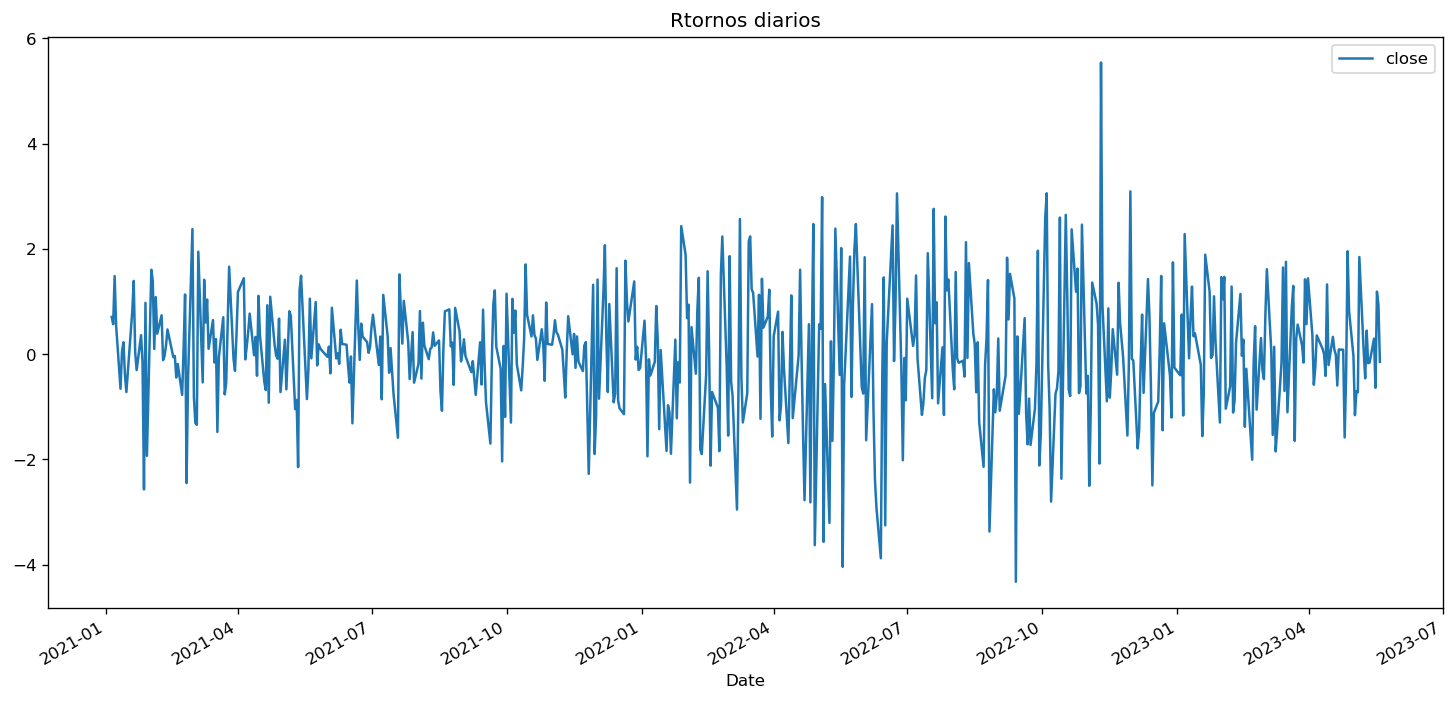

In [117]:
# retornos diarios sin acumulado
retornos.plot(figsize=(15,7),title='Rtornos diarios')

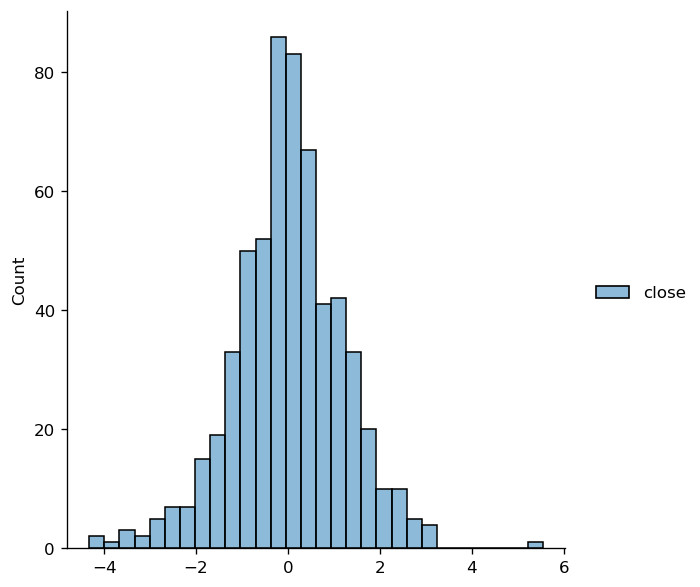

In [118]:
sns.displot(retornos)

In [119]:
kurtosis(retornos)

array([1.34270708])

In [120]:
print(f'la curtosis de los retornos es: {kurtosis(retornos)} \nla asimetria de los retornos es: {skew(retornos)}')

la curtosis de los retornos es: [1.34270708] 
la asimetria de los retornos es: [-0.12529074]


Se puede observar una distribucion platicurtica,es decir, los retornos tienen un pico mas agudo que una distribucion normal. Tambien se puede observar una asimetria negativa lo que indica que los retornos tienen una cola mas larga a la izquiera, es decir que hay mas retornos negativos que positivos

# Modelo GARCH 

En muchas series, como en las financieras, el número de retardos a utilizar es muy elevado, lo cual dificulta su estimación. Es por esto que Bollerslev (1986) propone un modelo en el cual la varianza condicional no solo depende de los cuadrados de los errores, como en el modelo GARCH, sino que además depende de las varianzas condicionales de periodos anteriores.

## Estacionariedad

Se buscará si los retornos del activo son estacionarios, ya que esto es un supuesto esencial a la hora de aplicar el modelo GARCH. En caso de no ser estacionarios, se deberá hacer un tratamiento como la diferenciación con el fin de buscar la estacionariedad.

### Grafica de los retornos

In [121]:
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

Un primer indicativo es la gráfica de la variable. A partir de esta gráfica, podemos observar varias cosas:

* Podemos ver que no muestra tendencias.
* Se observa una media constante alrededor de 0.
* También parece tener una varianza constante a lo largo del tiempo.

Estos son buenos indicios, ya que cumplen con los supuestos del modelo GARCH.


### Test de estacionariedad
* ADF :

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* PP:

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* KPSS :

$H_0$ = El proceso es debilmente estacionario

$H_1$ = El proceso contiene raiz unitaria

In [122]:
def Estacionariedad(data):
  """
  Realiza el test ADF, PP, KPSS sobre una serie de tiempo indicada en df 
  y una columna en especifico indicada en pais
  """
  adf_pvalue = round(ADF(data).pvalue, 6)
  pp_pvalue = round(PhillipsPerron(data).pvalue, 6)
  kpss_pvalue = round(KPSS(data).pvalue, 6)
  
  results = {'ADF': [adf_pvalue], 'PP': [pp_pvalue], 'KPSS': [kpss_pvalue]}
  df_tests = pd.DataFrame(results)
  
  return df_tests


In [123]:
Estacionariedad(retornos)

,ADF,PP,KPSS
0,0.0,0.0,0.44839


Como el p-valor es menor que $\alpha$, se rechaza $H_0$ para las pruebas de ADF y PP, y se acepta la prueba de KPSS. No parece haber presencia de unidad raíz en los retornos del activo. Por lo tanto, podemos concluir que los retornos son estacionarios.

## Grafica ACF y PACF

Otra forma de verificar la estacionariedad en los modelos es mediante las gráficas ACF y PACF. Si los rezagos de la serie convergen rápidamente al intervalo, podemos decir que la serie es estacionaria. Sin embargo, es importante mencionar que la convergencia rápida de los rezagos en las gráficas ACF y PACF no es suficiente para afirmar la estacionariedad, y que se deben realizar pruebas estadísticas adicionales para confirmarla.

c:\Users\Juan Guzman\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



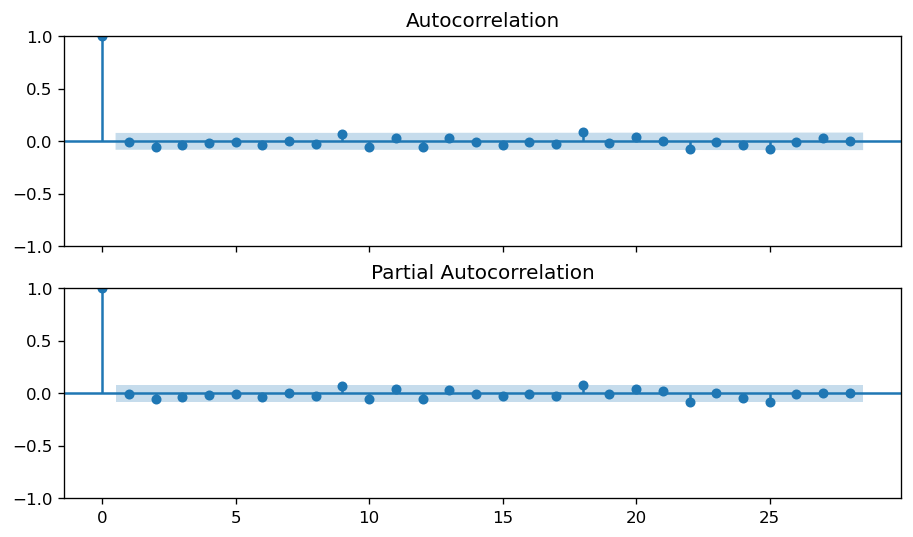

In [124]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=True)

plot_acf(retornos,ax=axes[0])
plot_pacf(retornos,ax=axes[1])
plt.show()

## Estimacion modelo

Se iniciara con la estimacion del modelo GARCH. 
Para determianr los valores de p,o,q se hara una simulacion de cross validation aunqeu no muy perfecta

Donde:
* p = Orden de retardo de la innovación simétrica
* o = Orden de retardo de la innovación asimétrica
* q = Orden de retraso de la volatilidad retrasada o equivalente

In [125]:
p = [1, 2, 3, 4, 5]
o = [1, 2, 3, 4, 5]
q = [1, 2, 3, 4, 5]

data = []
combinations = product(p, o, q)

for combination in combinations:
    p_val, o_val, q_val = combination
    modelo = arch_model(retornos, dist='ged', vol='Garch', p=p_val, o=o_val, q=q_val)
    modelo_fit = modelo.fit(disp='off')
    aic = modelo_fit.aic
    bic = modelo_fit.bic
    data.append([p_val, o_val, q_val, aic, bic])

df = pd.DataFrame(data, columns=['p', 'o', 'q', 'AIC', 'BIC'])

df.head()

,p,o,q,AIC,BIC
0,1,1,1,1787.455272,1813.816817
1,1,1,2,1789.434204,1820.189339
2,1,1,3,1790.348356,1825.497082
3,1,1,4,1791.235447,1830.777763
4,1,1,5,1793.123877,1837.059784


In [126]:
min_idx_AIC = df['AIC'].idxmin() # el indice con el valor mínimo del AIC
min_idx_BIC = df['BIC'].idxmin() # el indice con el valor mínimo del BIC
min_value_AIC = df.loc[min_idx_AIC, 'AIC'] # valor minimo del AIC
min_value_BIC = df.loc[min_idx_BIC, 'BIC'] # valor minimo del BIC
row_AIC = df.loc[min_idx_AIC, :] # demas columnas del minimo del AIC
row_BIC = df.loc[min_idx_BIC, :] # demas columnas del minimo del BIC
# Imprime los resultados
print("Mínimo de A:", min_value_AIC)
print("Fila correspondiente a mínimo de A:\n", row_AIC)
print("Mínimo de B:", min_value_BIC)
print("Fila correspondiente a mínimo de B:\n", row_BIC)

Mínimo de A: 1787.4552721266807
Fila correspondiente a mínimo de A:
 p         1.000000
o         1.000000
q         1.000000
AIC    1787.455272
BIC    1813.816817
Name: 0, dtype: float64
Mínimo de B: 1813.8168166503845
Fila correspondiente a mínimo de B:
 p         1.000000
o         1.000000
q         1.000000
AIC    1787.455272
BIC    1813.816817
Name: 0, dtype: float64


Se puede observar que el modelo que muestra los mejores valores tanto para el criterio de informacion de akaike como el bayesiano se tiene GARCH(p=1,o=1,q=1)

In [127]:
# Modelo definitivo
model = arch_model(retornos,dist='ged', vol='Garch',p=1,o=1,q=1) # dist = Nombre de la distribución de errores. vol = Nombre del modelo de volatilidad
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                          
==========================================================================================
Dep. Variable:                              close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:               -887.728
Distribution:      Generalized Error Distribution   AIC:                           1787.46
Method:                        Maximum Likelihood   BIC:                           1813.82
                                                    No. Observations:                  598
Date:                            Sun, May 21 2023   Df Residuals:                      597
Time:                                    20:29:06   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0356  3.945e-02      0.903      0.367 [-4.171e-02,  0.113]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0105  1.678e-02      0.624      0.533 [-2.241e-02,4.335e-02]
alpha[1]   4.3284e-10  5.972e-02  7.248e-09      1.000      [ -0.117,  0.117]
gamma[1]       0.1287  3.730e-02      3.450  5.597e-04    [5.560e-02,  0.202]
beta[1]        0.9285  6.406e-02     14.494  1.319e-47      [  0.803,  1.054]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.6109      0.166      9.683  3.574e-22 [  1.285,  1.937]
========================================================================

Covariance estimator: robust
"""

In [128]:
# definir la serie completa como el modelo previamente definido
full_serie_garch = arch_model(retornos,dist='ged',vol='GARCH',p=1,o=1,q=1)
# ajuste del modelo para la serie completa
model_fit_full_serie = full_serie_garch.fit(disp='off')

In [129]:
# conspiraremos contra la volatilidad rodante
# promedio movil de 15 dias de los rendimientos
rolling_vol = abs(retornos.rolling(window=15,min_periods=15).std().dropna())
rolling_vol

,close
Date,
2021-01-26,0.668991
2021-01-27,0.977675
2021-01-28,0.998550
2021-01-29,1.042418
2021-02-01,1.125609
...,...
2023-05-15,0.981210
2023-05-16,0.899217
2023-05-17,0.934022


In [130]:
# Concatenar los valores verdaderos y los entrenados por el modelo
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),rolling_vol.dropna()],axis=1).dropna()
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.715659,0.668991
2021-01-27,0.700271,0.977675
2021-01-28,1.156759,0.998550
2021-01-29,1.119303,1.042418
2021-02-01,1.292879,1.125609
...,...,...
2023-05-15,0.798554,0.981210
2023-05-16,0.776235,0.899217
2023-05-17,0.792633,0.934022


In [131]:
garch_and_rolling_std_plot = px.line(garch_and_rolling_std,
                                     title="GARCH vs volatilidad móvil de los retornos diarios")
garch_and_rolling_std_plot.show()

Se puede observar un buen comportamiento de los datos, luego se haran metricas de evaluacion para ver mejor su rendimiento 

Usando un rango de 90 dias para pronosticar los valores, para cada dia estamos ajustando un nuveo modelo con los mismos parametros, pero agregando el ultimo dia


In [132]:
test_size = 90
rolling_predictions = [] #90 predicciones

for i in range(test_size):
    train = retornos[:-(test_size-i)]
    model = arch_model(train,dist="ged",vol='GARCH',p=1,o=1,q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex=False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [133]:
rolling_predictions[:10] # primeros 10

[1.1222947249584203,
 1.0889180877720757,
 1.0496248958661123,
 1.0105234003654444,
 0.9743662438262103,
 1.1166765871015392,
 1.117792634282639,
 1.0859700107967973,
 1.052935675875532,
 1.0174833685567695]

In [134]:
# guardar las pred en un DF
rolling_pred = pd.DataFrame(rolling_predictions,index=retornos.index[-test_size:])
rolling_pred = rolling_pred.rename(columns={0:'pred'})
rolling_pred

,pred
Date,
2023-01-11,1.122295
2023-01-12,1.088918
2023-01-13,1.049625
2023-01-17,1.010523
2023-01-18,0.974366
...,...
2023-05-15,0.798474
2023-05-16,0.775192
2023-05-17,0.791097


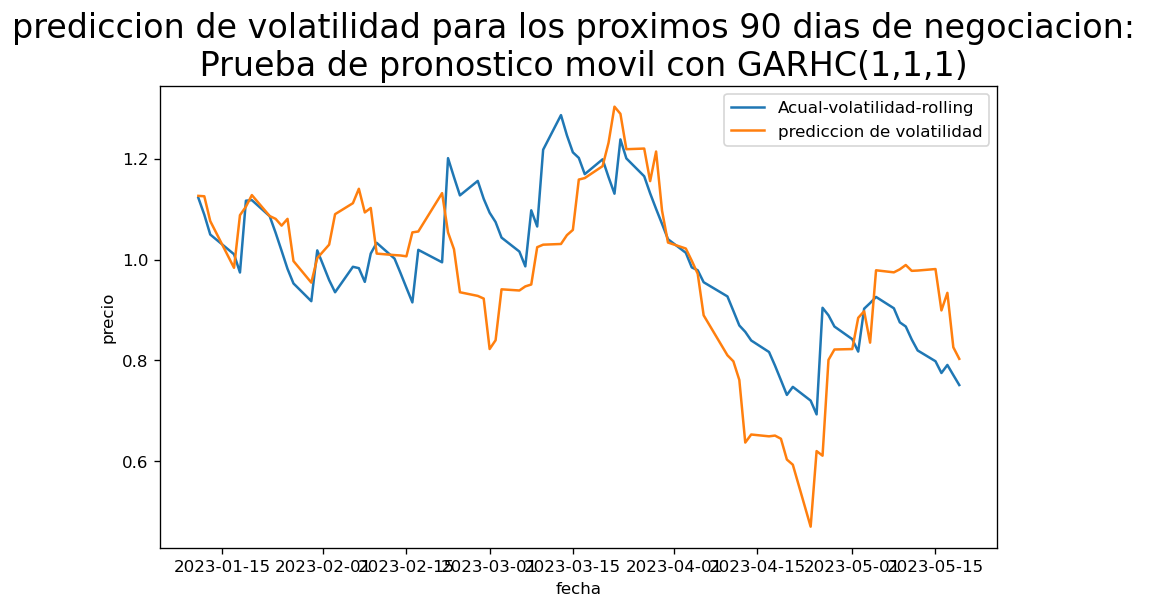

In [135]:
# graficar los datos reales y las predicciones de volatilidad
plt.plot(rolling_pred,label='Acual-volatilidad-rolling')
plt.plot((rolling_vol)[-test_size:],label='prediccion de volatilidad')
plt.title('prediccion de volatilidad para los proximos 90 dias de negociacion: \n Prueba de pronostico movil con GARHC(1,1,1)',fontsize=20)
plt.xlabel('fecha')
plt.ylabel('precio')
plt.legend()
plt.show()


# XGBOOST

XGBoost se basa en el concepto de Gradient Boosting, que es una técnica de ensamblaje que combina varios modelos débiles (normalmente árboles de decisión) para formar un modelo más robusto. El algoritmo entrena los árboles de forma secuencial, enfocándose en los errores residuales de los modelos anteriores

XGBoost es conocido por su excelente rendimiento en términos de precisión y velocidad. Dado que el S&P500 es un índice ampliamente seguido y se negocia activamente en los mercados financieros, la capacidad de predecir los retornos con alta precisión y en tiempo real es fundamental para los inversores y operadores.

In [136]:
df = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
df_ml = df[['Close']]
df_ml.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [137]:
# retornos
df_ml['retornos'] = 100 * df_ml['Close'].pct_change()
df_ml = df_ml.dropna()
df_ml.head()

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_3544\2464780598.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,retornos
Date,,
2021-01-05,3726.860107,0.708260
2021-01-06,3748.139893,0.570984
2021-01-07,3803.790039,1.484740
2021-01-08,3824.679932,0.549186
2021-01-11,3799.610107,-0.655475


In [138]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 598 entries, 2021-01-05 to 2023-05-19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     598 non-null    float64
 1   retornos  598 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


In [139]:
df_ml.describe()

,Close,retornos
count,598.000000,598.000000
mean,4164.300823,0.027882
std,283.913005,1.186419
min,3577.030029,-4.323661
25%,3934.917542,-0.667066
50%,4136.264893,0.016058
75%,4394.859863,0.739785
max,4796.560059,5.543448


In [140]:
# promedio movil de 22 dias
df_ml['win_22'] = abs(df_ml['retornos'].rolling(window=22,min_periods=22).std().dropna())
df_ml.head(16)

,Close,retornos,win_22
Date,,,
2021-01-05,3726.860107,0.708260,NaN
2021-01-06,3748.139893,0.570984,NaN
2021-01-07,3803.790039,1.484740,NaN
2021-01-08,3824.679932,0.549186,NaN
2021-01-11,3799.610107,-0.655475,NaN
2021-01-12,3801.189941,0.041579,NaN
2021-01-13,3809.840088,0.227564,NaN
2021-01-14,3795.540039,-0.375345,NaN
2021-01-15,3768.250000,-0.719003,NaN


In [141]:
df_ml.reset_index(inplace=True)

In [142]:
df_ml.info() #la fecha esta en tiempo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      598 non-null    datetime64[ns]
 1   Close     598 non-null    float64       
 2   retornos  598 non-null    float64       
 3   win_22    577 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 18.8 KB


In [143]:
# renombrar el df
serie_for_xgboost = df_ml
# establecer el tamaño del test
test_size = 90
# dividir el df en train y test
train_ml = serie_for_xgboost[:-(test_size)].dropna()
test_ml = serie_for_xgboost[-(test_size):].dropna()

In [144]:
train_ml.head()

,Date,Close,retornos,win_22
21,2021-02-04,3871.739990,1.085332,1.053701
22,2021-02-05,3886.830078,0.389750,1.048719
23,2021-02-08,3915.590088,0.739935,1.052205
24,2021-02-09,3911.229980,-0.111352,1.014038
25,2021-02-10,3909.879883,-0.034518,1.010222


In [145]:
train_ml.shape, test_ml.shape

((487, 4), (90, 4))

In [146]:
# extraer carac para series de tiempo
def create_features(df,label=None):
    '''
    Crear caracteristicas de fecha para el indice datetime
    '''
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day

    X = df[['dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X


In [147]:
X_train, y_train = create_features(train_ml, label="win_22")
X_test, y_test = create_features(test_ml, label="win_22")

In [148]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth
21,3,1,2,2021,35,4
22,4,1,2,2021,36,5
23,0,1,2,2021,39,8
24,1,1,2,2021,40,9
25,2,1,2,2021,41,10


In [149]:
# crear adicionalmente caracteristicas que usen los 4 dias previos de rolling volatility, incorporando el componente autorregresivo para nuesto modelo de ML
X_train['prev1'] = train_ml['win_22'].shift(1) # shift trae los rezagos
X_test['prev1'] = test_ml['win_22'].shift(1)
X_train['prev2'] = train_ml['win_22'].shift(2)
X_test['prev2'] = test_ml['win_22'].shift(2)
X_train['prev3'] = train_ml['win_22'].shift(3)
X_test['prev3'] = test_ml['win_22'].shift(3)

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_3544\2818475730.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_3544\2818475730.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_3544\2818475730.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [150]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,prev1,prev2,prev3
21,3,1,2,2021,35,4,NaN,NaN,NaN
22,4,1,2,2021,36,5,1.053701,NaN,NaN
23,0,1,2,2021,39,8,1.048719,1.053701,NaN
24,1,1,2,2021,40,9,1.052205,1.048719,1.053701
25,2,1,2,2021,41,10,1.014038,1.052205,1.048719
...,...,...,...,...,...,...,...,...,...
503,2,1,1,2023,4,4,1.098603,1.313358,1.313085
504,3,1,1,2023,5,5,1.120351,1.098603,1.313358
505,4,1,1,2023,6,6,1.136588,1.120351,1.098603
506,0,1,1,2023,9,9,1.211329,1.136588,1.120351


## Implementacion modelo XGBOOST

In [151]:
reg = xgb.XGBRFRegressor(n_stimators = 1000)
# entrenamiento del modelo
reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train),(X_test,y_test)],
                    verbose=False)

[20:29:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_stimators" } are not used.



XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, n_stimators=1000,
               num_parallel_tree=None, objective='reg:squarederror',
               predictor=None, random_state=None, ...)

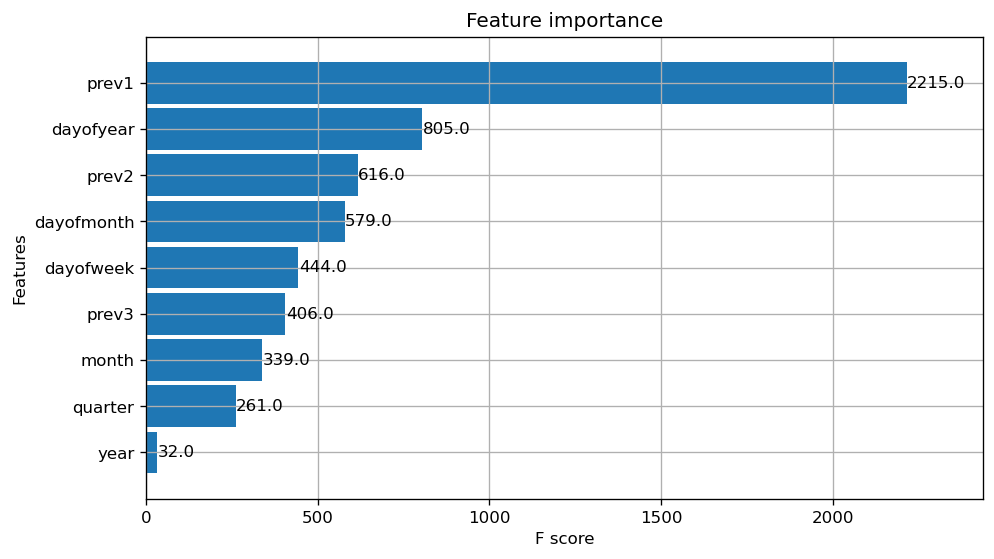

In [152]:
# visualizacion las variables de mas importancia en el modelo
__ = plot_importance(reg,height=0.9)

De la grafica inferimos que el primer rezago, dias del año y dias del mes las variables mas importantes

In [153]:
# realizamos las predicciones para train y test
train_ml['Predictions'] = reg.predict(X_train)
test_ml['Predictions'] = reg.predict(X_test)

In [154]:
# df con pred y real
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml['Predictions']),list(train_ml['win_22']))],axis=1).dropna().reset_index()
# renombramiento de columnas
XGBoost_and_rolling.rename(columns={'index':'Real_volatility',0:"Predicted Volatility"},inplace=True)
XGBoost_and_rolling.head()

,Real_volatility,Predicted Volatility
0,1.053701,1.195051
1,1.048719,1.042282
2,1.052205,1.040213
3,1.014038,1.036804
4,1.010222,1.031335


In [155]:
XGBoost_and_rolling.set_index(train_ml['Date'],inplace=True)

In [107]:
XGBoost_and_rolling = px.line(XGBoost_and_rolling,
                              title="XGBOOST vs GARCH vs volatilidad móvil de los retornos para el entrenamiento")
XGBoost_and_rolling.show()

In [50]:
test_ml.set_index('Date',inplace=True)

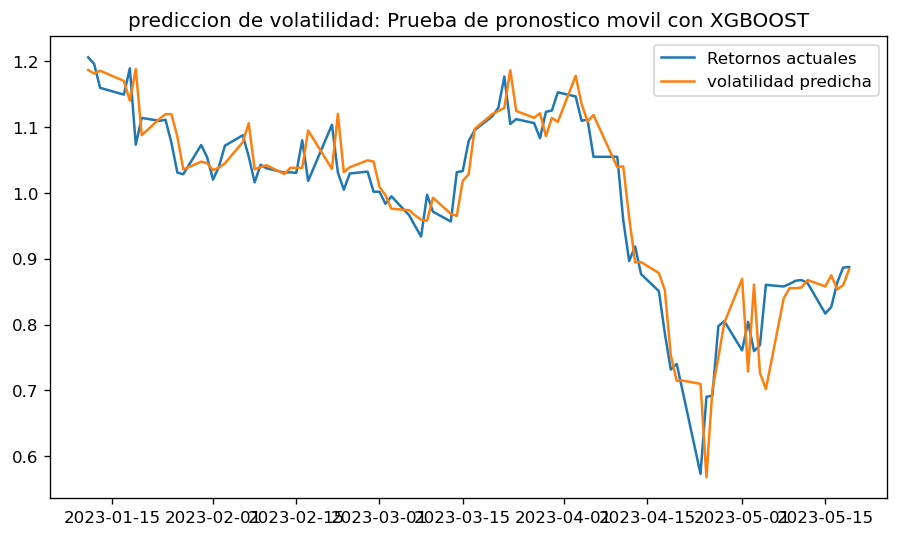

In [51]:
true, = plt.plot(test_ml['win_22'])
preds, = plt.plot(test_ml['Predictions'])
plt.title('prediccion de volatilidad: Prueba de pronostico movil con XGBOOST')
plt.legend(['Retornos actuales','volatilidad predicha'])

# Evaluacion

* Root Mean Squared Error (RMSE):

El RMSE es una métrica comúnmente utilizada para medir la precisión de un modelo de regresión. Se calcula tomando la raíz cuadrada del error cuadrático medio, que a su vez se obtiene promediando los errores cuadrados entre los valores predichos y los valores reales.

El RMSE se expresa en las mismas unidades que la variable objetivo y proporciona una medida de la diferencia promedio entre los valores predichos y los valores reales. Un RMSE más bajo indica una mayor precisión del modelo, ya que implica que los valores predichos se ajustan mejor a los valores reales.

* Mean Absolute Percentage Error (MAPE):

El MAPE es una métrica utilizada para evaluar la precisión de un modelo en términos de porcentaje de error absoluto promedio en relación con los valores reales. Se calcula tomando el promedio de los errores absolutos porcentuales entre los valores predichos y los valores reales, y multiplicándolo por 100 para obtener un porcentaje.

El MAPE proporciona una medida relativa del error promedio en términos porcentuales, lo que permite comparar la precisión entre diferentes modelos y conjuntos de datos. Un MAPE más bajo indica una mayor precisión del modelo, ya que implica que los valores predichos tienen un menor porcentaje de diferencia con respecto a los valores reales.

In [52]:
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.715659,0.668991
2021-01-27,0.700271,0.977675
2021-01-28,1.156759,0.998550
2021-01-29,1.119303,1.042418
2021-02-01,1.292879,1.125609
...,...,...
2023-05-15,0.798554,0.981210
2023-05-16,0.776235,0.899217
2023-05-17,0.792633,0.934022


In [53]:
RMSE_serie = mean_squared_error(garch_and_rolling_std['close'],garch_and_rolling_std['cond_vol'],squared=False)
MAPE_serie = mean_absolute_percentage_error(garch_and_rolling_std['close'],garch_and_rolling_std['cond_vol'])
print(f"el RMSE del modelo GARCH en los datos de la serie completa es: {round(RMSE_serie,4)}")
print(f"el MAPE del modelo GARCH en los datos de la serie completa es: {round(MAPE_serie*100,4)}%")

el RMSE del modelo GARCH en los datos de la serie completa es: 0.1898
el MAPE del modelo GARCH en los datos de la serie completa es: 15.1482%


In [54]:
true_vol = rolling_vol[-test_size:]
pred_vol = rolling_predictions
RMSE = mean_squared_error(true_vol,pred_vol,squared=False)
MAPE = mean_absolute_percentage_error(true_vol,pred_vol)
print(f"el RMSE del modelo GARCH en los datos predichos es: {round(RMSE,4)}")
print(f"el MAPE del modelo GARCH en los datos predichos es: {round(MAPE*100,4)}%")

el RMSE del modelo GARCH en los datos predichos es: 0.1195
el MAPE del modelo GARCH en los datos predichos es: 10.9324%


In [55]:
RMSE_Serie_XG = mean_squared_error(train_ml['win_22'],train_ml['Predictions'],squared=False)
MAPE_serie_XG = mean_absolute_percentage_error(train_ml['win_22'],train_ml['Predictions'])
print(f"el RMSE del modelo XGBOOST en los datos de la serie completa es: {round(RMSE_Serie_XG,4)}")
print(f"el MAPE del modelo XGBOOST en los datos de la serie completa es: {round(MAPE_serie_XG*100,4)}%")

el RMSE del modelo XGBOOST en los datos de la serie completa es: 0.0338
el MAPE del modelo XGBOOST en los datos de la serie completa es: 2.2842%


In [57]:
true_vol = test_ml['Predictions']
pred_vol = test_ml['win_22']
RMSE_XG=mean_squared_error(true_vol,pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol,pred_vol)
print(f"el RMSE del modelo XGBOOST en los datos pevistos es: {round(RMSE_XG,4)}")
print(f"el MAPE del modelo XGBOOST en los datos pedichos es: {round(MAPE_XG*100,4)}%")

el RMSE del modelo XGBOOST en los datos pevistos es: 0.0467
el MAPE del modelo XGBOOST en los datos pedichos es: 3.5515%
